In [1]:
# imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
%matplotlib inline
sns.set(style="whitegrid", font_scale=1.5, rc={'figure.figsize':(12, 6)})

# for custom notebook formatting.
from IPython.core.display import HTML
display(HTML('<style>.prompt{width: 0px; min-width: 0px; visibility: collapse}</style>'))
HTML(open('../custom.css').read())

<br><br><br>

## Natural Language Processing
### :::: Word2Vec ::::

<br><br><br><br><br><br>


## Word Vectors

Last week we sketched an idea of how to use neural nets to learn informative word representations:

<img src="figs/nn.png" width=70%/>

- Word vectors become hidden nodes in a neural network.
- An additional hidden layer allows non-linear transformations of word vectors
- Training the model to optimize $p(w_i \mid v_{i-1} \ldots v_{i-n})$ results in "useful" vectors for $v$.
- **Word representations are useful if they help us predict the next word in a sentence.**


<br>

Implementation: `sklearn`'s `MLPClassifier` class supports only a limited set of structures for neural nets. 

```python
MLPClassifier(hidden_layer_sizes=[50, 10])
```

In fact, we can't build the network above -- it would look like this instead:

<img src="figs/nnbroken.png" width=70%/>

What's the difference and why does it matter?

<br>

Instead we will use PyTorch <https://pytorch.org/>
- Very mature, open-source library for training neural nets
- Developed at Facebook research


<br><br>
Let's start with a somewhat simpler model:

<img src="figs/smallnn.png" width=50%/>


Given an input word, predict what other word appears nearby.






<br>

## Debugging neural nets

Once we start designing our own networks, it is very easy to make a mistake.

It is helpful to start with a small, easy dataset where we know what the network should do.

If we don't get near perfect accuracy on such data, then something is wrong with our implementation.

Here, we'll learn word embeddings for an artificially easy task:

Two words appear near each other iff they start with the same letter:

> "All aardvarks ate apples."

> "Both bobcats broke bottles." 

We will generate a dataset of **word pairs** $(w_1, w_2)$ indicating that $w_1$ occurrs near $w_2$.

In [75]:
animals = ['aardvark', 'albatross', 'alligator', 'alpaca', 'anole', 'ant', 'anteater', 'antelope', 'ape', 'armadillo',
           'baboon', 'badger', 'barracuda', 'bat', 'bear', 'bee', 'bison', 'boar', 'bobcat', 'butterfly']
vocab = {w: i for i,w in enumerate(animals)}
a_names = [a for a in animals if a[0] == 'a']
b_names = [b for b in animals if b[0] == 'b']


def make_animal_data():
    np.random.seed(42)
    animal_data = pd.DataFrame(zip(np.random.choice(a_names, size=300), np.random.choice(a_names, size=300)),
                              columns=['w1', 'w2'])
    animal_data = pd.concat((animal_data,
                           pd.DataFrame(zip(np.random.choice(b_names, size=300), np.random.choice(b_names, size=300)),
                              columns=['w1', 'w2'])))
    animal_data = animal_data.sample(frac=1, random_state=42)
    # remove where w1==w2
    animal_data = animal_data[animal_data.w1 != animal_data.w2]#.drop_duplicates()
    return animal_data
data = make_animal_data()
data

,w1,w2
110,aardvark,ant
119,bat,bear
265,bee,butterfly
77,ape,albatross
181,anole,armadillo
...,...,...
121,armadillo,aardvark
20,anole,ant
71,anole,ant
270,alpaca,albatross


<img src="figs/smallnn.png" width=50%/>

## PyTorch

PyTorch has a number of classes to help create an train neural nets. Some important concepts:

**[Tensor](https://pytorch.org/tutorials/beginner/blitz/tensor_tutorial.html#sphx-glr-beginner-blitz-tensor-tutorial-py)**: Multimensional arrays, very similar to `numpy` arrays. Optimized for GPU usage.

```python
data = [[1, 2],[3, 4]]
torch.tensor(data)
```

```
tensor([[1, 2],
        [3, 4]])
```

**[automatic differentiation](https://pytorch.org/tutorials/beginner/blitz/autograd_tutorial.html)**: PyTorch will perform back propagation automatically to compute the gradients for each parameter. It can do this by restricting somewhat the network structures activation functions. See [`torch.nn`](https://pytorch.org/docs/stable/nn.html).

Creating a network consists of a few steps:

1. Create a Python class that subclasses `torch.nn.Module`.
2. In the constructor, define the structure of the network (layers, activation functions)
3. Implement a method called `forward` that computes the forward pass of the neural net. This applies each transformation defined in the constructor in the approriate order and produces an output.
4. Write a method to generate batches of training data.
5. Pick an optimizer to perform gradient descent.

Let's walk through how the above model is implemented in PyTorch.

In [160]:
import torch
import torch.nn as nn
import math

class WordPairModel(nn.Module):
    def __init__(self, vocab_size, embedding_size, verbose=True):
        super(WordPairModel, self).__init__()
        self.verbose = verbose
        # input -> hidden
        # linear == x*A^T + b =~ dense neural net layer
        self.embedding = nn.Linear(vocab_size, embedding_size, bias=False)
        # hidden -> output
        self.hidden = nn.Linear(embedding_size, vocab_size, bias=False)
        # normalize
        self.softmax = nn.Softmax(dim=1)
        
    def forward(self, input):
        if self.verbose: print('input\n', input)
            
        embedding = self.embedding(input)
        if self.verbose: print('embedding\n', embedding)

        hidden = self.hidden(embedding)
        if self.verbose: print('hidden\n', hidden)

        output = self.softmax(hidden)
        if self.verbose: print('softmax\n', output)
        return output

- `nn.Linear`: $x A^T + b$
- **embedding**:
  - Input: one-hot encoded word vector $w_1 \in \mathbb{R}^V$. e.g. $<0,1,0 \ldots 0>$
  -  model parameters $A \in \mathbb{R}^{V x H}$
    - $V$: vocabulary size
    - $H$: embedding size
    
- **hidden**:
  - Input: embedding vector $h \in \mathbb{R}^H$. e.g. $<.22,-.01,.3 \ldots 1.2>$
  - model parameters $A \in \mathbb{R}^{H x V}$


- **softmax**

$$
\hbox{softmax}(x) = \frac{e^x}{\sum_i e^{x_i}}
$$
- exponentiate: make things positive
- normalize so it sums to one for all possible outputs.
- How many $x_i$ are there in our model?

<br><br>

Next, we have to convert all of our word pairs into appropriate **tensor** data structures.

In [161]:
def vectorize_one(word, vocabulary):
    """ one-hot encoding"""
    tensor = torch.zeros(1, len(vocabulary))
    tensor[0][vocabulary[word]] = 1.0
    return tensor

def vectorize_batch(rows, vocabulary):
    """
    encode all examples in given list of rows in DataFrame.
    """
    return (torch.cat([vectorize_one(w, vocabulary) for w in rows.w1]),
            torch.cat([vectorize_one(w, vocabulary) for w in rows.w2]))
    
vectorize_one('aardvark', vocab)

tensor([[1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0.]])

In [162]:
# vectorize first three rows.
vectorize_batch(data.iloc[:3], vocab)

(tensor([[1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
          0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.,
          0., 0.]]),
 tensor([[0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.,
          0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 1.]]))

In [163]:
# Compute forward pass for first example.
# Note the weights are randomly initialized.
model = WordPairModel(len(vocab), embedding_size=2)
output = model(vectorize_batch(data.iloc[:1], vocab)[0])

input
 tensor([[1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0.]])
embedding
 tensor([[-0.1155, -0.1281]], grad_fn=<MmBackward>)
hidden
 tensor([[ 0.0335,  0.0670,  0.1089,  0.0994, -0.0505, -0.0985,  0.0065,  0.0572,
          0.1578, -0.0036,  0.0425,  0.0058, -0.0048, -0.1153, -0.0026,  0.0184,
          0.0767, -0.0079, -0.0755,  0.0224]], grad_fn=<MmBackward>)
softmax
 tensor([[0.0507, 0.0525, 0.0547, 0.0542, 0.0466, 0.0445, 0.0494, 0.0519, 0.0574,
         0.0489, 0.0512, 0.0493, 0.0488, 0.0437, 0.0489, 0.0500, 0.0530, 0.0487,
         0.0455, 0.0502]], grad_fn=<SoftmaxBackward>)


In [164]:
# look at the embedding weights
model.embedding.weight

Parameter containing:
tensor([[-0.1155, -0.1524,  0.1186, -0.0904,  0.1357, -0.0531,  0.1279, -0.1737,
         -0.1128,  0.0682,  0.0473, -0.0570,  0.1333,  0.1520, -0.1622, -0.1194,
          0.2047, -0.0755, -0.0793, -0.2164],
        [-0.1281,  0.0559, -0.0295, -0.1623,  0.0052, -0.1527, -0.1897, -0.1231,
         -0.1957, -0.1424,  0.2235,  0.0422,  0.0689, -0.2086, -0.1469, -0.0744,
          0.0350, -0.1968, -0.0963, -0.1339]], requires_grad=True)

In [165]:
# .forward() does the following:
i = vectorize_batch(data.iloc[:1], vocab)[0]
print('i:', i)
e = i.mul(model.embedding.weight).sum(dim=1)
print('embedding:', e)
h = e.mul(model.hidden.weight).sum(dim=1)
print('hidden:', h)
o =  h.exp() / h.exp().sum()
print('output:', s)

i: tensor([[1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0.]])
embedding: tensor([-0.1155, -0.1281], grad_fn=<SumBackward1>)
hidden: tensor([ 0.0335,  0.0670,  0.1089,  0.0994, -0.0505, -0.0985,  0.0065,  0.0572,
         0.1578, -0.0036,  0.0425,  0.0058, -0.0048, -0.1153, -0.0026,  0.0184,
         0.0767, -0.0079, -0.0755,  0.0224], grad_fn=<SumBackward1>)
output: tensor([0.0511, 0.0541, 0.0502, 0.0498, 0.0459, 0.0520, 0.0492, 0.0475, 0.0485,
        0.0517, 0.0489, 0.0515, 0.0510, 0.0469, 0.0475, 0.0474, 0.0527, 0.0533,
        0.0524, 0.0484], grad_fn=<DivBackward0>)


In [166]:
# map from output distribution to predicted word.
def output2label(output, words):
    # 0 if false is most probable prediction, 1 if true
    top_n, top_i = output.topk(1)
    return words[top_i.item()] # , math.exp(top_n)

output2label(output, animals)

'ape'

100%|██████████| 40/40 [00:00<00:00, 67.53it/s]


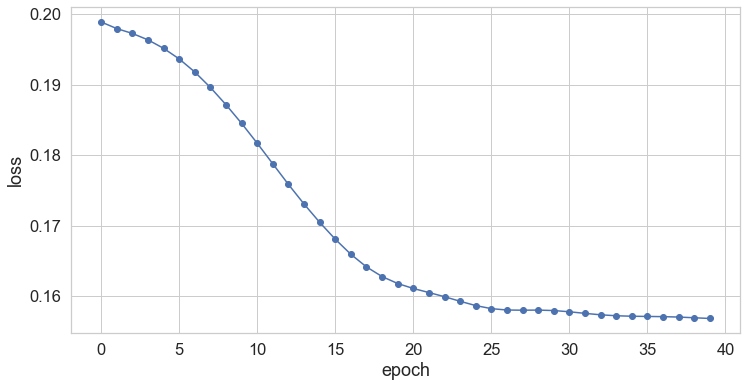

In [167]:
def train_word_pair(data, vocab):
    torch.random.manual_seed(42)  # for reproducibility
    learning_rate = 0.1
    model = WordPairModel(len(vocab), embedding_size=2)
    # binary cross entropy
    # choice of loss function depends on output type of model
    criterion = nn.BCELoss()
    # fancier version of gradient descent
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate) 
    model.verbose = False

    loss_val = []
    num_epochs = 40
    # main training loop
    for epoch in tqdm(range(num_epochs), total=num_epochs):
        optimizer.zero_grad() # reset all the gradient information
        inputs, labels = vectorize_batch(data, vocab)
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()      # computes all the gradients
        optimizer.step()     # update parameters
        loss_val.append(loss.item())

    plt.figure()
    plt.plot(loss_val, 'bo-')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.show()
    return model

word_pair_model = train_word_pair(data, vocab)

In [168]:
# get embedding for a word
def word2embedding(word, model, vocabulary):
    return model.embedding(vectorize_one(word, vocabulary)).detach().cpu().numpy()[0]
word2embedding('ant', word_pair_model, vocab)

array([ 2.047941  , -0.50115424], dtype=float32)

In [169]:
word2embedding('aardvark', word_pair_model, vocab)

array([3.0145164 , 0.02156257], dtype=float32)

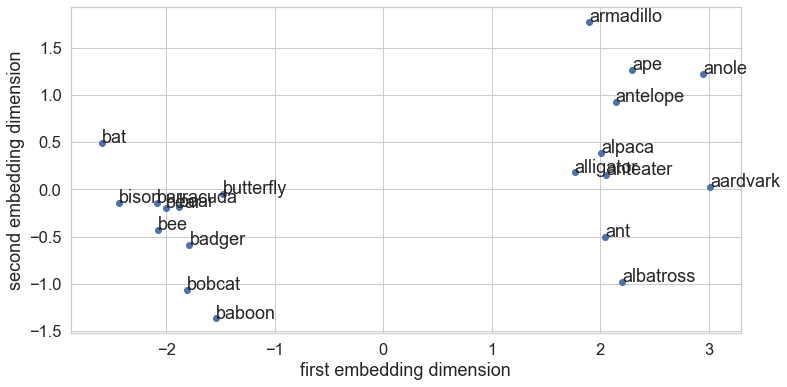

In [170]:
def plot_embeddings(animal_embeddings, animals):
    plt.figure()
    plt.scatter([e[0] for e in animal_embeddings],
                [e[1] for e in animal_embeddings])
    for animal, embed in zip(animals, animal_embeddings):
        plt.annotate(animal, (embed[0], embed[1]))
    plt.xlabel('first embedding dimension')
    plt.ylabel('second embedding dimension')
    plt.show()
    
animal_embeddings = [word2embedding(animal, word_pair_model, vocab) for animal in animals]
plot_embeddings(animal_embeddings, animals)

In [174]:
# how many parameters in our model?
print(word_pair_model)

WordPairModel(
  (embedding): Linear(in_features=20, out_features=2, bias=False)
  (hidden): Linear(in_features=2, out_features=20, bias=False)
  (softmax): Softmax(dim=1)
)


<br><br><br><br><br>


$V \times H \times V$

$V$: vocabulary size

$H$: embedding size

<br><br><br>

One trick for scalability: rather than predict a word, predict whether the two given words appear next to each other:

<img src="figs/nn2.png" width=80%/>

So, input has doubled, but output is now a single binary variable.

<br><br>
But wait, do we really need the additional hidden layer? 
<br>
We really just want the two word vectors to be similar for positive examples and dissimilar for negative examples.

<br><br>
Let's take the dot product 

<img src="figs/w2v.png" width=60%/>

<br><br>

How do we get negative examples?

<br><br><br>

Just sample words that do not appear near each other.

In [175]:
# add negative examples
def add_negatives(data):
    np.random.seed(42)
    data2 = data.copy()
    data2 = pd.concat((data2,
                      pd.DataFrame(zip(np.random.choice(a_names, size=400), np.random.choice(b_names, size=400)), columns=['w1', 'w2'])))
    data2 = pd.concat((data2,
                      pd.DataFrame(zip(np.random.choice(b_names, size=400), np.random.choice(a_names, size=400)), columns=['w1', 'w2'])))

    data2['label'] = [1 if w1[0] == w2[0] else 0 for (w1, w2) in data2.values]
    data2 = data2.sample(frac=1, random_state=42).drop_duplicates()
    return data2
data2 = add_negatives(data)
data2

,w1,w2,label
290,badger,bee,1
341,ape,boar,0
93,bobcat,boar,1
200,baboon,bison,1
187,barracuda,baboon,1
...,...,...,...
160,ant,anteater,1
233,aardvark,alligator,1
240,bobcat,antelope,0
97,anteater,ant,1


In [176]:
def vectorize_batch2(rows, vocabulary):
    """
    return (input_tensor, output_tensor) tuple
    for all examples in rows.
    """
    label_vocab = {0: 0, 1: 1}
    return (torch.cat([vectorize_one(w, vocabulary) for w in rows.w1]),
            torch.cat([vectorize_one(w, vocabulary) for w in rows.w2]),
            torch.tensor([float(l) for l in rows.label]))
vectorize_batch2(data2.iloc[:3], vocab)

(tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.,
          0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          1., 0.]]),
 tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.,
          0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.,
          0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.,
          0., 0.]]),
 tensor([1., 0., 1.]))

In [177]:
# compare with earlier method.
vectorize_batch(data2.iloc[:3], vocab)

(tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.,
          0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          1., 0.]]),
 tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.,
          0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.,
          0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.,
          0., 0.]]))

In [180]:
# embed w1 and w2 separately, take their dot product, then predict binary classification.
class Word2Vec(nn.Module):
    def __init__(self, vocab_size, embedding_size, verbose=True):
        super(Word2Vec, self).__init__()
        self.verbose = verbose
        self.embedding = nn.Linear(vocab_size, embedding_size, bias=False)
        self.sigmoid = nn.Sigmoid()

    def forward(self, w1, w2):
        if self.verbose: print('w1\n', w1, '\nw2\n', w2)            
        embedding1 = self.embedding(w1)
        embedding2 = self.embedding(w2)
        if self.verbose: print('embedding1\n', embedding1, '\nembedding2\n', embedding2)
            
        dotprod = torch.mul(embedding1, embedding2).sum(dim=1)
        if self.verbose: print('dotprod\n', dotprod)

        output = self.sigmoid(dotprod)
        if self.verbose: print('sigmoid\n', output)
        return output

torch.random.manual_seed(42)
w2v = Word2Vec(len(vocab), 2, verbose=True)
print(w2v)
# test model
bb = vectorize_batch2(data2.iloc[:3], vocab)
output = w2v(bb[0], bb[1])
print(output)

Word2Vec(
  (embedding): Linear(in_features=20, out_features=2, bias=False)
  (sigmoid): Sigmoid()
)
w1
 tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.,
         0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         1., 0.]]) 
w2
 tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.,
         0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.,
         0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.,
         0., 0.]])
embedding1
 tensor([[ 0.0419, -0.1899],
        [ 0.1971,  0.0211],
        [-0.1044,  0.0244]], grad_fn=<MmBackward>) 
embedding2
 tensor([[-0.0316,  0.1382],
        [ 0.0331,  0.1807],
        [ 0.0331,  0.1807]], grad_fn=<MmBackward>)
dotprod
 tensor([-0.0276,  0.0103,  0.0010], grad_fn=<S

  0%|          | 0/15 [00:00<?, ?it/s]

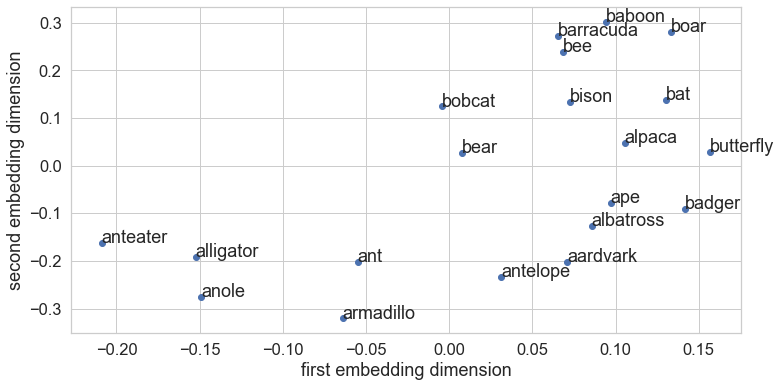

  7%|▋         | 1/15 [00:00<00:03,  4.24it/s]

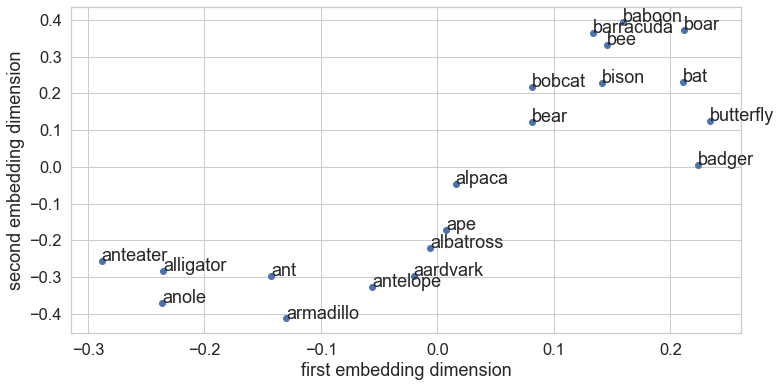

 13%|█▎        | 2/15 [00:00<00:03,  3.85it/s]

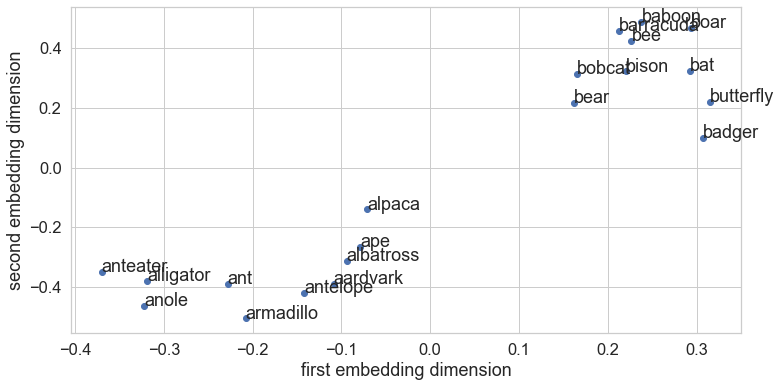

 20%|██        | 3/15 [00:00<00:03,  3.85it/s]

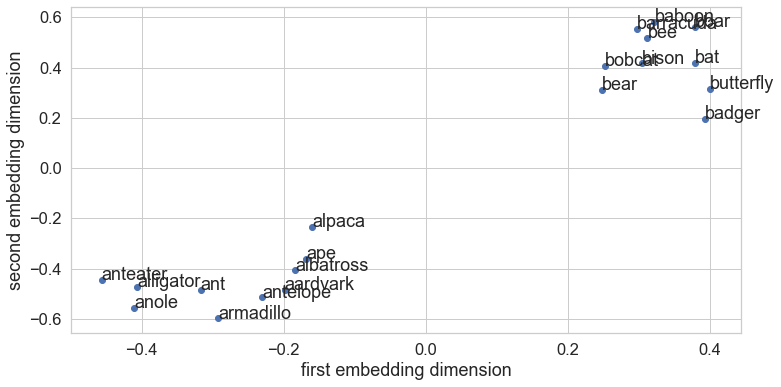

 27%|██▋       | 4/15 [00:01<00:02,  3.97it/s]

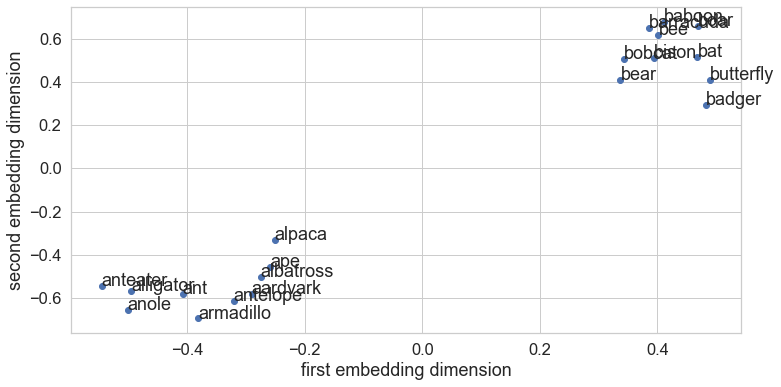

 33%|███▎      | 5/15 [00:01<00:02,  4.03it/s]

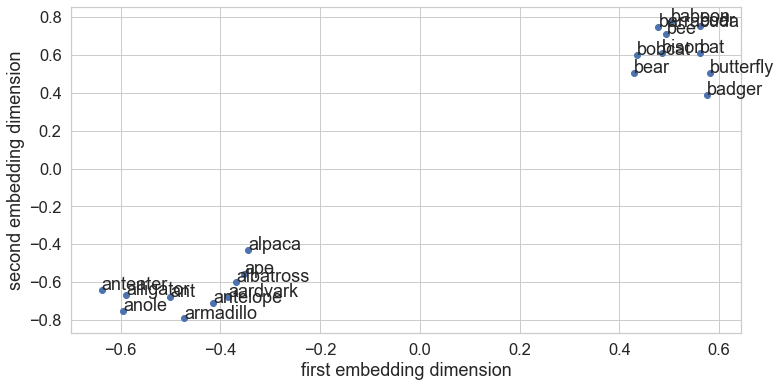

 40%|████      | 6/15 [00:01<00:02,  4.01it/s]

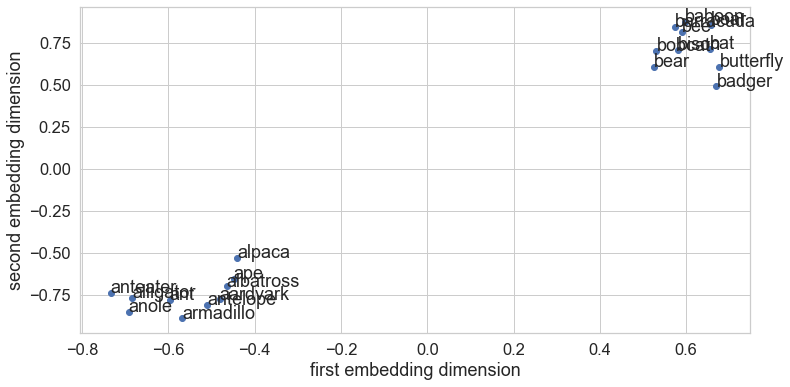

 47%|████▋     | 7/15 [00:01<00:02,  4.00it/s]

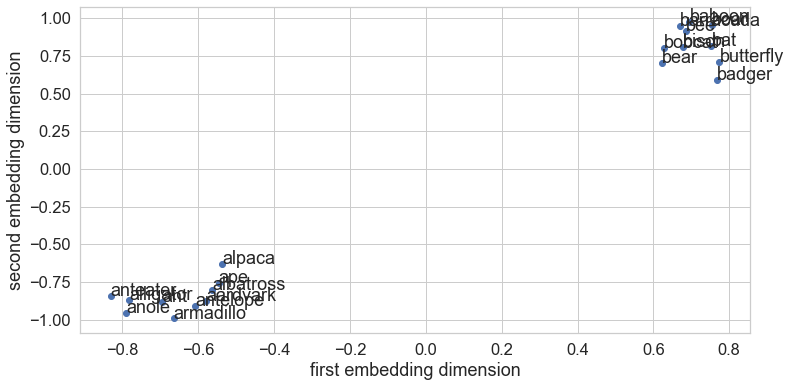

 53%|█████▎    | 8/15 [00:02<00:01,  3.75it/s]

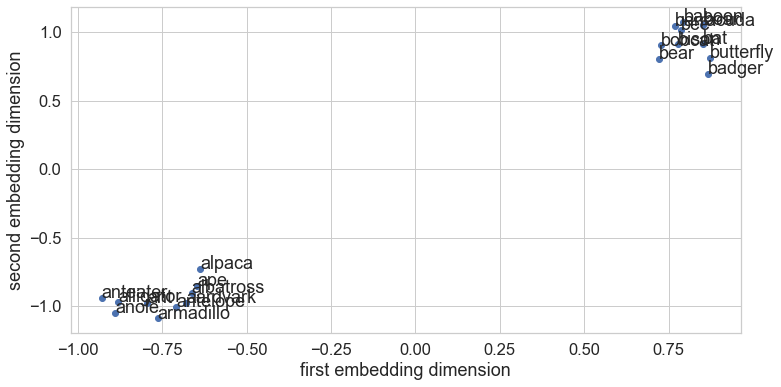

 60%|██████    | 9/15 [00:02<00:01,  3.83it/s]

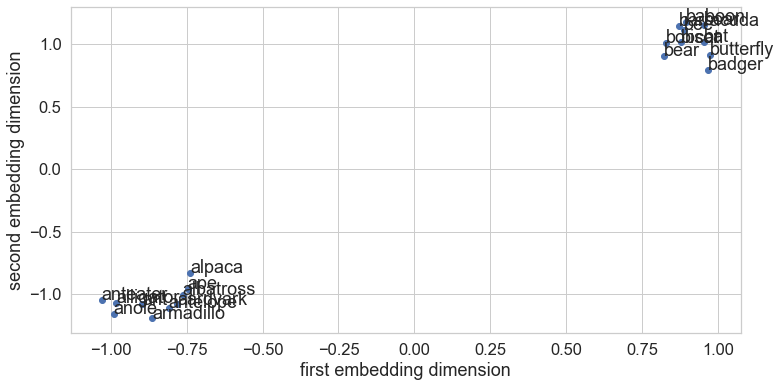

 67%|██████▋   | 10/15 [00:02<00:01,  3.96it/s]

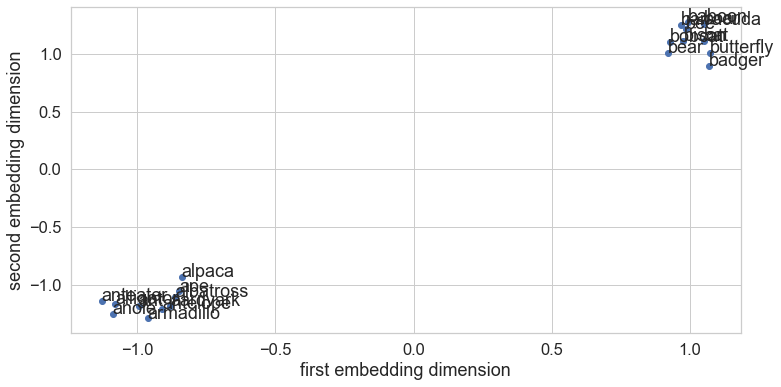

 73%|███████▎  | 11/15 [00:02<00:00,  4.05it/s]

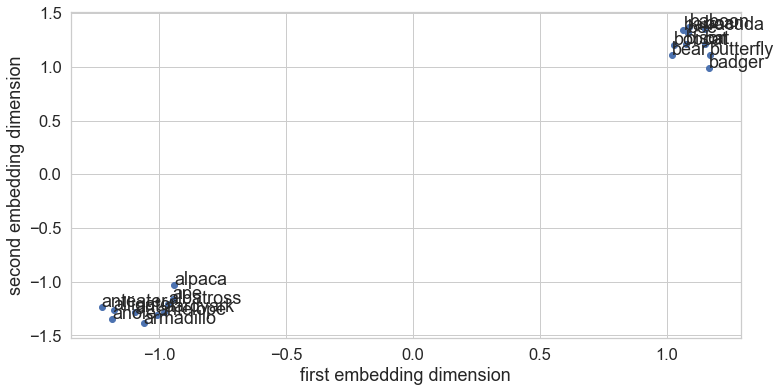

 80%|████████  | 12/15 [00:03<00:00,  4.02it/s]

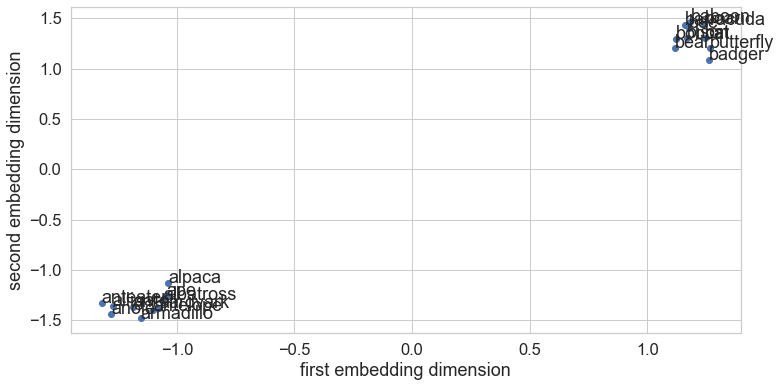

 87%|████████▋ | 13/15 [00:03<00:00,  3.98it/s]

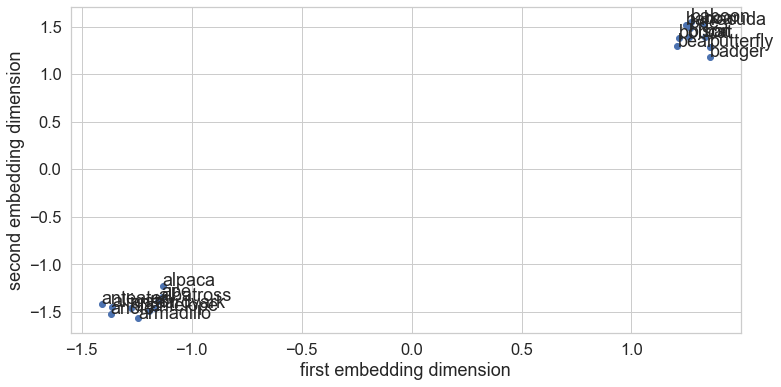

 93%|█████████▎| 14/15 [00:03<00:00,  3.99it/s]

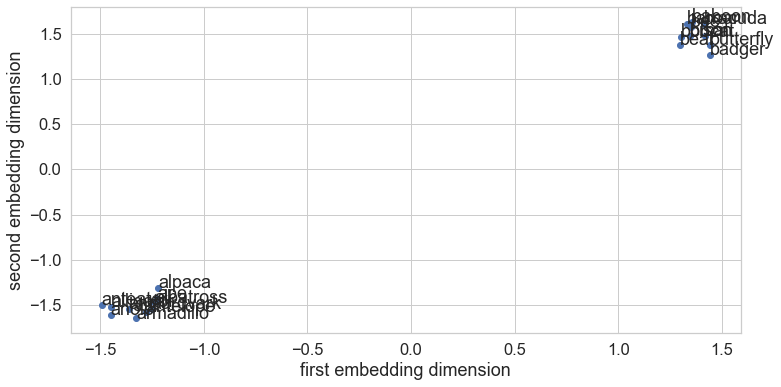

100%|██████████| 15/15 [00:03<00:00,  3.87it/s]


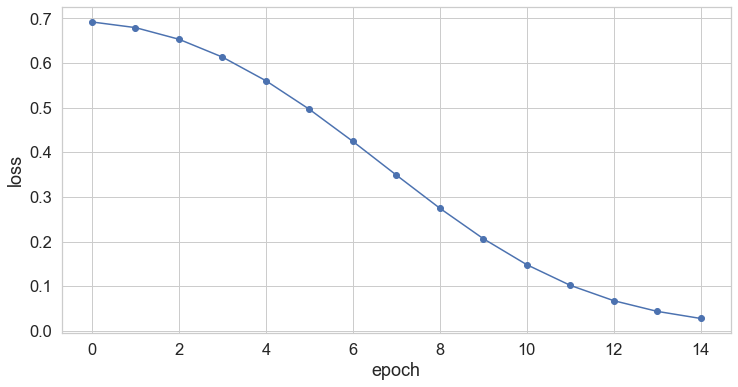

In [181]:
def train_word2vec(data, vocab):
    torch.random.manual_seed(42)
    learning_rate = 0.1
    model = Word2Vec(len(vocab), embedding_size=2)
    criterion = nn.BCELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate) 
    model.verbose = False

    loss_val = []
    num_epochs=15
    for epoch in tqdm(range(num_epochs), total=num_epochs):
        optimizer.zero_grad() # reset all the gradient information
        words1, words2, labels = vectorize_batch2(data, vocab)
        outputs = model(words1, words2)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        loss_val.append(loss.item())
        animal_embeddings = [word2embedding(animal, model, vocab) for animal in animals]
        plot_embeddings(animal_embeddings, animals)

    plt.figure()
    plt.plot(loss_val, 'bo-')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.show()
    return model

w2v = train_word2vec(data2, vocab)

<br><br>


### Pretrained embeddings

There are many open-source word embeddings that have been pretrained on terabytes of data.

In [265]:
# download Google's pretrained word2vec vectors ~1 Gb
# also available here: https://drive.google.com/u/0/uc?id=0B7XkCwpI5KDYNlNUTTlSS21pQmM
import gensim
import gensim.downloader as api
w2v = api.load('word2vec-google-news-300')
# word2vec = torch.FloatTensor(weights.vectors)

In [267]:
w2v.vocab

{'</s>': <gensim.models.keyedvectors.Vocab at 0x183cc2b20>,
 'in': <gensim.models.keyedvectors.Vocab at 0x183d2b280>,
 'for': <gensim.models.keyedvectors.Vocab at 0x183d73bb0>,
 'that': <gensim.models.keyedvectors.Vocab at 0x183d60d30>,
 'is': <gensim.models.keyedvectors.Vocab at 0x183d60bb0>,
 'on': <gensim.models.keyedvectors.Vocab at 0x183d60b20>,
 '##': <gensim.models.keyedvectors.Vocab at 0x183d60ca0>,
 'The': <gensim.models.keyedvectors.Vocab at 0x183d60e20>,
 'with': <gensim.models.keyedvectors.Vocab at 0x183d60ee0>,
 'said': <gensim.models.keyedvectors.Vocab at 0x183d60b50>,
 'was': <gensim.models.keyedvectors.Vocab at 0x183d60f40>,
 'the': <gensim.models.keyedvectors.Vocab at 0x183d60c40>,
 'at': <gensim.models.keyedvectors.Vocab at 0x183d60d90>,
 'not': <gensim.models.keyedvectors.Vocab at 0x183d60fa0>,
 'as': <gensim.models.keyedvectors.Vocab at 0x183d60d60>,
 'it': <gensim.models.keyedvectors.Vocab at 0x183cff940>,
 'be': <gensim.models.keyedvectors.Vocab at 0x183cff8e0>,
 

In [266]:
len(w2v.vocab)

3000000

In [268]:
w2v['love']

array([ 0.10302734, -0.15234375,  0.02587891,  0.16503906, -0.16503906,
        0.06689453,  0.29296875, -0.26367188, -0.140625  ,  0.20117188,
       -0.02624512, -0.08203125, -0.02770996, -0.04394531, -0.23535156,
        0.16992188,  0.12890625,  0.15722656,  0.00756836, -0.06982422,
       -0.03857422,  0.07958984,  0.22949219, -0.14355469,  0.16796875,
       -0.03515625,  0.05517578,  0.10693359,  0.11181641, -0.16308594,
       -0.11181641,  0.13964844,  0.01556396,  0.12792969,  0.15429688,
        0.07714844,  0.26171875,  0.08642578, -0.02514648,  0.33398438,
        0.18652344, -0.20996094,  0.07080078,  0.02600098, -0.10644531,
       -0.10253906,  0.12304688,  0.04711914,  0.02209473,  0.05834961,
       -0.10986328,  0.14941406, -0.10693359,  0.01556396,  0.08984375,
        0.11230469, -0.04370117, -0.11376953, -0.0037384 , -0.01818848,
        0.24316406,  0.08447266, -0.07080078,  0.18066406,  0.03515625,
       -0.09667969, -0.21972656, -0.00328064, -0.03198242,  0.18

In [269]:
 w2v.distance("love", "hate")

0.3996043801307678

In [272]:
w2v.distance('love', 'school')

0.9043338373303413

In [273]:
w2v.most_similar(positive=['ant'])

[('ants', 0.7326952815055847),
 ('insect', 0.6691938638687134),
 ('grasshoppers', 0.576737642288208),
 ('spider', 0.5640506744384766),
 ('ant_colony', 0.5585130453109741),
 ('cockroach', 0.5551185607910156),
 ('ant_nest', 0.5531710386276245),
 ('insects', 0.5530052185058594),
 ('wasp', 0.5481342077255249),
 ('beetle', 0.5468916893005371)]

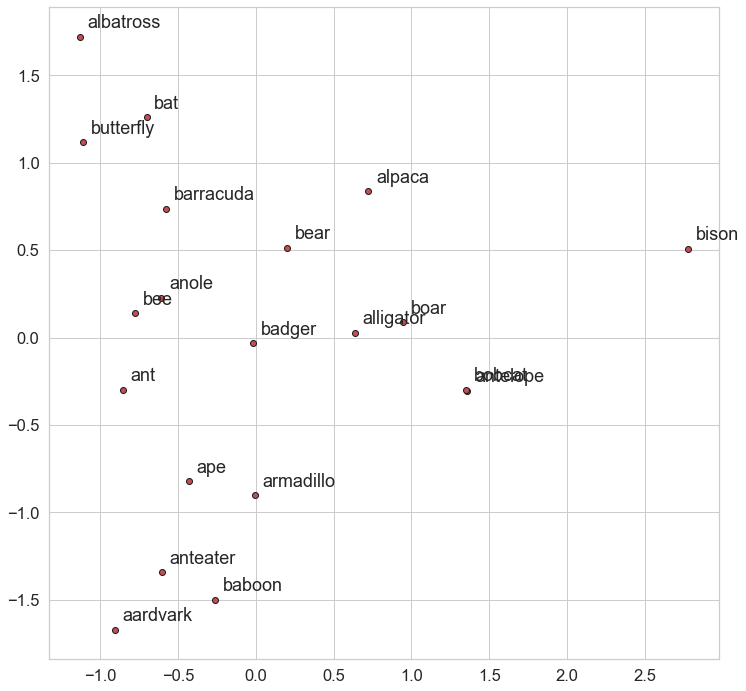

In [292]:
from sklearn.decomposition import PCA
def plot_embeddings(w2v, words):
    word_vectors = np.array([w2v[a] for a in words])
    # reduce two 2 dimensions
    twodim = PCA(random_state=42).fit_transform(word_vectors)[:,:2]
    plt.figure(figsize=(12,12))
    plt.scatter(twodim[:,0], twodim[:,1], edgecolors='k', c='r')
    for word, (x,y) in zip(words, twodim):
        plt.text(x+.05, y+.05, word)
    plt.show()
    
plot_embeddings(w2v, animals)

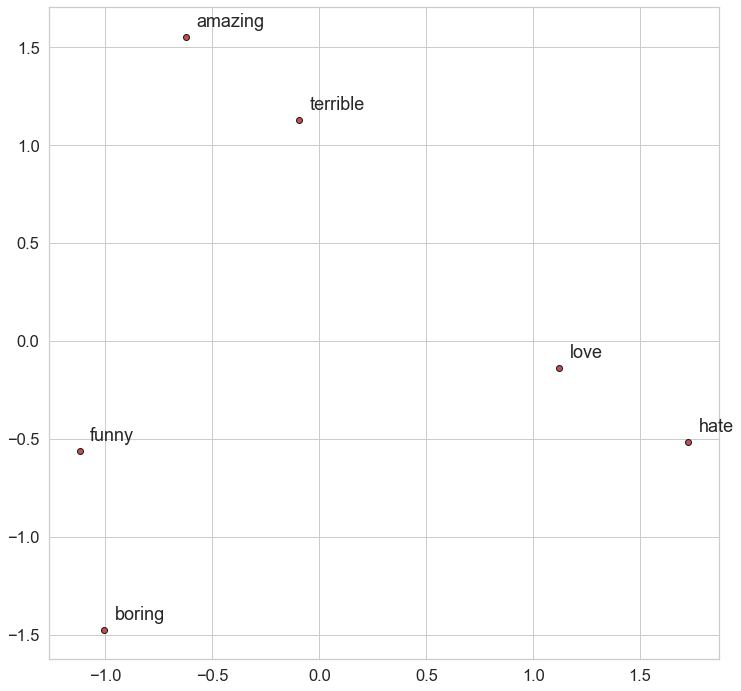

In [293]:
plot_embeddings(w2v, ['love', 'hate', 'funny', 'boring', 'amazing', 'terrible'])

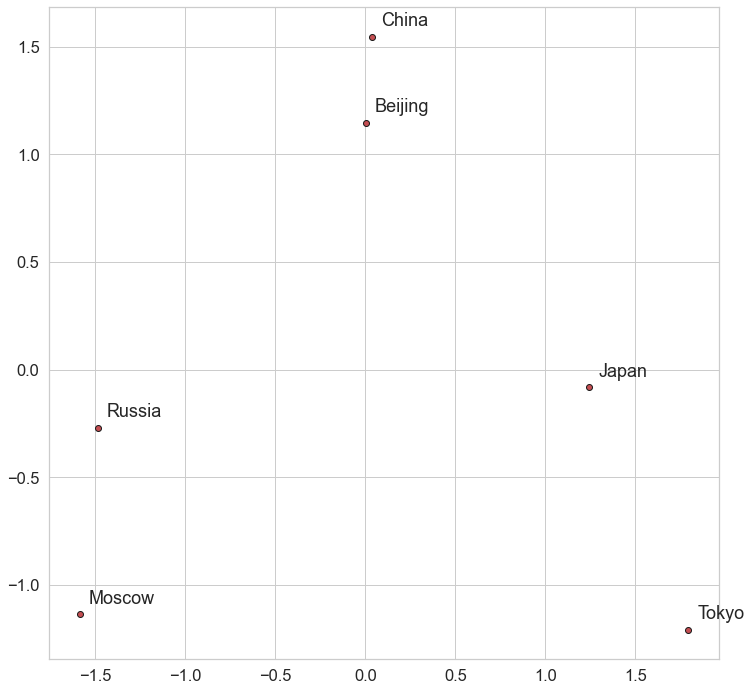

In [294]:
plot_embeddings(w2v, ['China', 'Beijing', 'Russia', 'Moscow', 'Japan', 'Tokyo'])

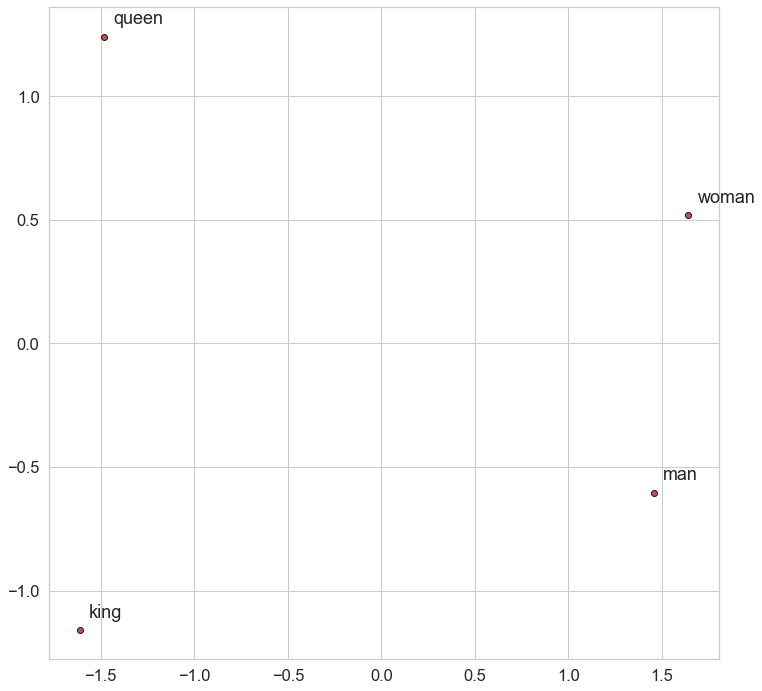

In [295]:
plot_embeddings(w2v, ['king', 'queen', 'man', 'woman'])

## analogy task

a::b c::?

woman::man  queen::king


king - man + woman =~ queen ?

In [305]:



w2v.most_similar(positive=['king', 'woman'], negative=['man'])




[('queen', 0.7118192911148071),
 ('monarch', 0.6189674139022827),
 ('princess', 0.5902431011199951),
 ('crown_prince', 0.5499460697174072),
 ('prince', 0.5377321243286133),
 ('kings', 0.5236844420433044),
 ('Queen_Consort', 0.5235945582389832),
 ('queens', 0.518113374710083),
 ('sultan', 0.5098593235015869),
 ('monarchy', 0.5087411999702454)]

In [306]:


queenlike = w2v['king'] - w2v['man'] + w2v['woman']
queenlike



array([ 4.29687500e-02, -1.78222656e-01, -1.29089355e-01,  1.15234375e-01,
        2.68554688e-03, -1.02294922e-01,  1.95800781e-01, -1.79504395e-01,
        1.95312500e-02,  4.09919739e-01, -3.68164062e-01, -3.96484375e-01,
       -1.56738281e-01,  1.46484375e-03, -9.30175781e-02, -1.16455078e-01,
       -5.51757812e-02, -1.07574463e-01,  7.91015625e-02,  1.98974609e-01,
        2.38525391e-01,  6.34002686e-02, -2.17285156e-02,  0.00000000e+00,
        4.72412109e-02, -2.17773438e-01, -3.44726562e-01,  6.37207031e-02,
        3.16406250e-01, -1.97631836e-01,  8.59375000e-02, -8.11767578e-02,
       -3.71093750e-02,  3.15551758e-01, -3.41796875e-01, -4.68750000e-02,
        9.76562500e-02,  8.39843750e-02, -9.71679688e-02,  5.17578125e-02,
       -5.00488281e-02, -2.20947266e-01,  2.29492188e-01,  1.26403809e-01,
        2.49023438e-01,  2.09960938e-02, -1.09863281e-01,  5.81054688e-02,
       -3.35693359e-02,  1.29577637e-01,  2.41699219e-02,  3.48129272e-02,
       -2.60009766e-01,  

In [307]:



w2v.most_similar(positive=['father', 'woman'], negative=['man'])





[('mother', 0.8462507724761963),
 ('daughter', 0.7899606823921204),
 ('husband', 0.7560455799102783),
 ('son', 0.7279756665229797),
 ('eldest_daughter', 0.7120417952537537),
 ('niece', 0.7096832990646362),
 ('aunt', 0.6960804462432861),
 ('grandmother', 0.6897341012954712),
 ('sister', 0.6895190477371216),
 ('daughters', 0.6731119751930237)]

In [308]:








w2v.most_similar(positive=['computer_programmer', 'woman'], negative=['man'])

[('homemaker', 0.5627118945121765),
 ('housewife', 0.5105047225952148),
 ('graphic_designer', 0.505180299282074),
 ('schoolteacher', 0.49794942140579224),
 ('businesswoman', 0.49348920583724976),
 ('paralegal', 0.4925510883331299),
 ('registered_nurse', 0.49079740047454834),
 ('saleswoman', 0.4881627559661865),
 ('electrical_engineer', 0.4797726571559906),
 ('mechanical_engineer', 0.4755399823188782)]

<br><br><br>

## Bias!

Models trained on data can replicate and/or amplify existing stereotypes.

<br><br><br>

<img src="figs/rec.png" width=50%/>

[source](https://spectrum.ieee.org/tech-talk/telecom/internet/women-less-likely-to-be-shown-ads-for-highpaying-jobs)
- Fairness in recommendation systems
- Experiment: create fake Google profiles, then search for jobs
- Only difference was gender
> The male profiles were much more likely to be shown ads for a career coaching service for executive positions paying over $200,000. The Google ad network showed this ad to the male users more than 1800 times, but only about 300 times to women.